<h1><center>Leak occurrence detection code</center></h1>


------
## Importing required libraries: 

In [343]:

import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.nn as nn
from tqdm.auto import tqdm
import torch.optim as optim
from sklearn import metrics

In [344]:
#%reset

-------
## Audio Utilities: 

In [345]:
class AudioUtil ():
    
    @staticmethod
    def open (audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr) 
    
    @staticmethod
    def spectro_gram (aud, n_mels = 16, n_fft = 1024, hop_len = 1024/2):
        sig, sr = aud
        top_db = 80
        spec = transforms.MelSpectrogram(sr,n_fft = n_fft,n_mels = n_mels, hop_length = hop_len)(sig)
        spec = transforms.AmplitudeToDB(top_db = top_db)(spec)
        return (spec)
    
 

-----------
## Sound data set: 

In [346]:
class SoundDS (Dataset): 
    
    def __init__ (self, df, data_path):
        self.df = df
        self.data_path = str (data_path)
        self.sr = 48000
        
    def __len__ (self):        
        return (len(self.df))
        
    def __getitem__(self, idx):
        audio_file = self.data_path + self.df.loc[idx, "realtive_path"]
        class_id = torch.tensor(self.df.loc[idx, 'Y'])
        aud = AudioUtil.open(audio_file)
        sgram = AudioUtil.spectro_gram(aud,  n_fft=1024,n_mels = 64, hop_len= 1024)
        sgram_m, sgram_s = sgram.mean(), sgram.std()
        sgram = (sgram -  sgram_m)/sgram_s

        return sgram, class_id

------
## Building a model:

In [347]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, num_classes=5):
        super(NeuralNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(64*141, 128) # Fully connected layer with 100 hidden neurons
        self.fc2 = torch.nn.Linear(128, 64) # Fully connected layer with num_classes outputs
        self.fc3 = torch.nn.Linear(64, 64) # Fully connected layer with num_classes outputs
        self.fc4 = torch.nn.Linear(64, 32) # Fully connected layer with num_classes outputs
        self.fc5 = torch.nn.Linear(32, num_classes) # Fully connected layer with num_classes outputs
 
    def forward(self, x):
        x = x.view(-1,64*141) # reshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return F.log_softmax(x,-1)

In [348]:
import torch
import torch.nn as nn
import torch.optim as optim

 

class CNNModel(nn.Module):
    def __init__(self,num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(5,5), stride=1, padding=1)
        self.act1 = nn.ReLU()
        #self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(5,5), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
         
        self.fc3 = nn.Linear(65280,512)
        self.act3 = nn.ReLU()
        #self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, num_classes)
 
    def forward(self, x):

        x = self.act1(self.conv1(x))
        #x = self.drop1(x)
 
        x = self.act2(self.conv2(x))
 
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        #x = self.drop3(x)

        x = self.fc4(x)
        return F.log_softmax(x,-1)
 

---------
## Experiment (1): 

In [349]:
df = pd.read_csv("/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/Dataframes/LO_exp1.csv.csv")
df.head()
data_path=r'/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code'
myds = SoundDS(df, data_path)

In [350]:
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
# Create training and validation data loaders
train_dl =torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=True)
print(num_train)
print(num_val)


1200
300


In [351]:
l = 1 
inputs = []
labels = []
for i,j in myds:
    inputs.append(i)
    labels.append(j)
    l +=1 
    if l == num_items:
        break

In [352]:
inputs[5].shape

torch.Size([1, 64, 141])

In [353]:
model = NeuralNetwork(num_classes = 2)

In [354]:
# train the model
num_epochs = 40
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
pbar = tqdm(total = num_epochs)
# Loop through the number of epochs
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    # iterate over the training data
    for data in train_dl:
        inputs, labels = data[0], data[1] 
        outputs = model(inputs)
        #compute the loss       
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # increment the running loss and accuracy
        #print(loss.item())
        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == labels).sum().item()
        #print((outputs.argmax(1) == labels).sum())
    # calculate the average training loss and accuracy
    train_loss /= len(train_dl)
    train_loss_history.append(train_loss)
    train_acc /= len(train_dl.dataset)
    train_acc_history.append(train_acc)

    # set the model to evaluation mode
    #model.eval()
    with torch.no_grad():
        for inputs, labels in val_dl:
            outputs = model(inputs)
            loss = F.nll_loss(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == labels).sum().item()

    # calculate the average validation loss and accuracy
    val_loss /= len(val_dl)
    val_loss_history.append(val_loss)
    val_acc /= len(val_dl.dataset)
    val_acc_history.append(val_acc)
    pbar.update(1)

    print(f'Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, train loss: 0.1335, train acc: 0.9742, val loss: 0.0000, val acc: 1.0000
Epoch 2/40, train loss: 0.0000, train acc: 1.0000, val loss: 0.0000, val acc: 1.0000
Epoch 3/40, train loss: 0.0000, train acc: 1.0000, val loss: 0.0000, val acc: 1.0000
Epoch 4/40, train loss: 0.0000, train acc: 1.0000, val loss: 0.0000, val acc: 1.0000
Epoch 5/40, train loss: 0.0000, train acc: 1.0000, val loss: 0.0000, val acc: 1.0000
Epoch 6/40, train loss: 0.0000, train acc: 1.0000, val loss: 0.0000, val acc: 1.0000
Epoch 7/40, train loss: 0.0000, train acc: 1.0000, val loss: 0.0000, val acc: 1.0000
Epoch 8/40, train loss: 0.0000, train acc: 1.0000, val loss: 0.0000, val acc: 1.0000
Epoch 9/40, train loss: 0.0000, train acc: 1.0000, val loss: 0.0000, val acc: 1.0000
Epoch 10/40, train loss: 0.0000, train acc: 1.0000, val loss: 0.0000, val acc: 1.0000
Epoch 11/40, train loss: 0.0000, train acc: 1.0000, val loss: 0.0000, val acc: 1.0000
Epoch 12/40, train loss: 0.0000, train acc: 1.0000, val loss: 0

In [377]:
modelc = CNNModel(num_classes=2)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelc.parameters(), lr=0.001)
 
n_epochs = 40
pbar1 = tqdm(total = n_epochs)
for epoch in range(n_epochs):
    for inputs, labels in train_dl:

        # forward, backward, and then weight update
        y_pred = modelc(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    acc = 0
    count = 0
    for inputs, labels in val_dl:
        y_pred = modelc(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    pbar1.update(1)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))
 
#torch.save(model.state_dict(), "cifar10model.pth")


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0: model accuracy 100.00%
Epoch 1: model accuracy 100.00%
Epoch 2: model accuracy 100.00%
Epoch 3: model accuracy 100.00%
Epoch 4: model accuracy 100.00%
Epoch 5: model accuracy 100.00%
Epoch 6: model accuracy 100.00%
Epoch 7: model accuracy 100.00%
Epoch 8: model accuracy 100.00%
Epoch 9: model accuracy 100.00%
Epoch 10: model accuracy 100.00%
Epoch 11: model accuracy 100.00%
Epoch 12: model accuracy 100.00%
Epoch 13: model accuracy 100.00%
Epoch 14: model accuracy 100.00%
Epoch 15: model accuracy 100.00%
Epoch 16: model accuracy 100.00%
Epoch 17: model accuracy 100.00%
Epoch 18: model accuracy 100.00%
Epoch 19: model accuracy 100.00%
Epoch 20: model accuracy 100.00%
Epoch 21: model accuracy 100.00%
Epoch 22: model accuracy 100.00%
Epoch 23: model accuracy 100.00%
Epoch 24: model accuracy 100.00%
Epoch 25: model accuracy 100.00%
Epoch 26: model accuracy 100.00%
Epoch 27: model accuracy 100.00%
Epoch 28: model accuracy 100.00%
Epoch 29: model accuracy 100.00%
Epoch 30: model accu

----------
## Experiment (2): 

### 1. Low-level noise: 

In [378]:
df1 = pd.read_csv("/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/Dataframes/LO_exp2_0.csv")
data_path=r'/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code'
myds1 = SoundDS(df1, data_path)

In [379]:
test_dl =torch.utils.data.DataLoader(myds1, batch_size=len(myds1), shuffle=False)

#### 1. ANN model: 

In [380]:
for inputs, labels in test_dl: 
    a1 = model(inputs)
    results1 = torch.argmax(a1, 1)
    acc = (results1 == labels).float().sum()
    #print(results)
    b1 = labels
    print(acc/len(b1))

tensor(0.8467)


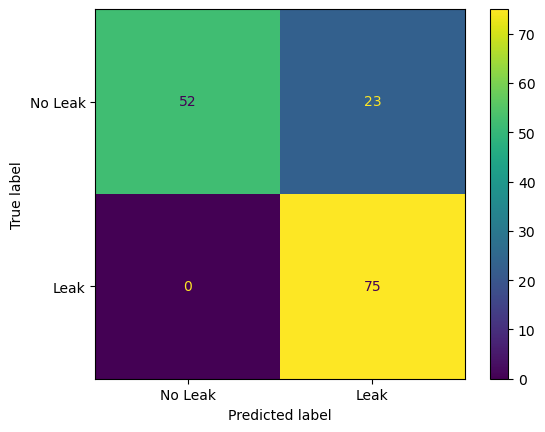

In [381]:
confusion_matrix = metrics.confusion_matrix(b1, results1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Leak", "Leak"])
cm_display.plot()
cm_display.im_.set_clim(0, 75) #this is very imprtant
plt.show()

#### 2. CNN model: 

In [382]:
for inputs, labels in test_dl: 
    a = modelc(inputs)
    results = torch.argmax(a, 1)
    acc = (results == labels).float().sum()
    #print(results)
    b = labels
    print(acc/len(b))

tensor(0.8400)


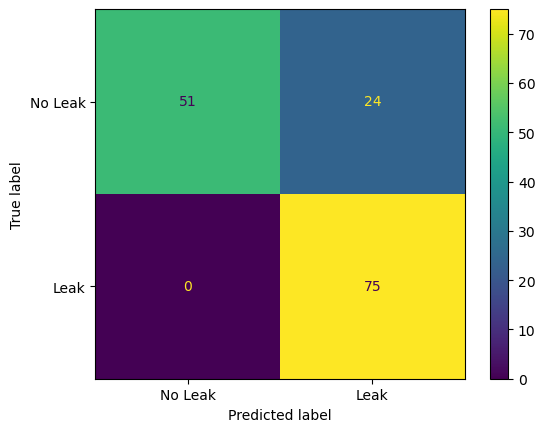

In [383]:
confusion_matrix = metrics.confusion_matrix(b, results)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Leak", "Leak"])
cm_display.plot()
cm_display.im_.set_clim(0, 75) #this is very imprtant
plt.show()

#### 3. ROC curve: 

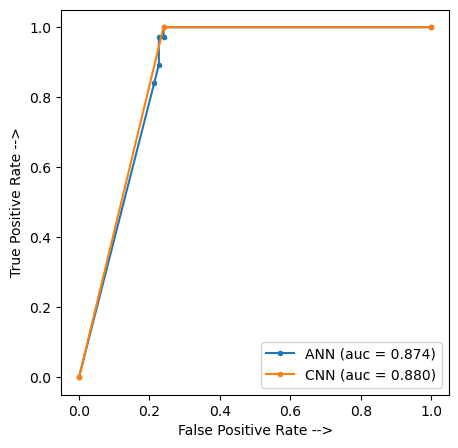

In [417]:
from sklearn.metrics import roc_curve, auc

with torch.no_grad():
    cnn_fpr, cnn_tpr, threshold = roc_curve(b, a[:,1])
    auc_cnn = auc(cnn_fpr, cnn_tpr)
    ann_fpr, ann_tpr, threshold = roc_curve(b1, a1[:,1])
    auc_ann = auc(ann_fpr, ann_tpr)

    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(ann_fpr, ann_tpr, linestyle='-',marker='.', label='ANN (auc = %0.3f)' % auc_ann)
    plt.plot(cnn_fpr, cnn_tpr, marker='.', label='CNN (auc = %0.3f)' % auc_cnn)

    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')

    plt.legend()

    plt.show()

### 2. High-level noise: 


In [387]:
df1 = pd.read_csv("/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/Dataframes/LO_exp2_1.csv")
data_path=r'/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code'
myds1 = SoundDS(df1, data_path)

In [388]:
test_dl =torch.utils.data.DataLoader(myds1, batch_size=len(myds1), shuffle=False)

#### 1. ANN model: 

In [389]:
for inputs, labels in test_dl: 
    a2 = model(inputs)
    results2 = torch.argmax(a1, 1)
    acc = (results2 == labels).float().sum()
    #print(results)
    b2 = labels
    print(acc/len(b2))

tensor(0.8467)


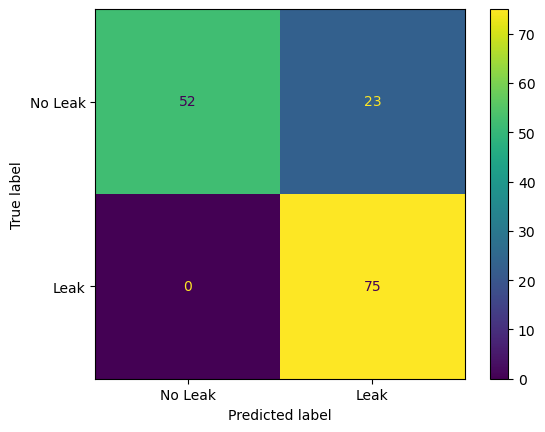

In [390]:
confusion_matrix = metrics.confusion_matrix(b2, results2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Leak", "Leak"])
cm_display.plot()
cm_display.im_.set_clim(0, 75) #this is very imprtant
plt.show()

#### 2. CNN model: 

In [392]:
for inputs, labels in test_dl: 
    a3 = modelc(inputs)
    results3 = torch.argmax(a3, 1)
    acc = (results3 == labels).float().sum()
    #print(results)
    b3 = labels
    print(acc/len(b3))

tensor(0.6933)


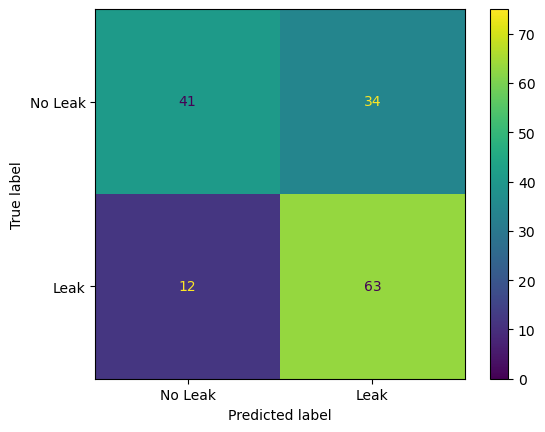

In [393]:
confusion_matrix = metrics.confusion_matrix(b3, results3)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Leak", "Leak"])
cm_display.plot()
cm_display.im_.set_clim(0, 75) #this is very imprtant
plt.show()

#### 3. ROC curve: 

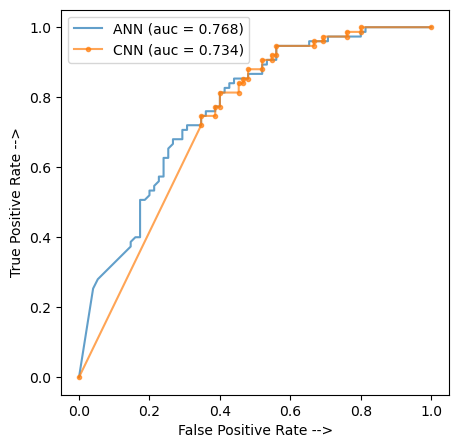

In [396]:
from sklearn.metrics import roc_curve, auc

with torch.no_grad():
    cnn_fpr, cnn_tpr, threshold = roc_curve(b3, a3[:,1])
    auc_cnn = auc(cnn_fpr, cnn_tpr)
    ann_fpr, ann_tpr, threshold = roc_curve(b2, a2[:,1])
    auc_ann = auc(ann_fpr, ann_tpr)

    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(ann_fpr, ann_tpr, linestyle='-', label='ANN (auc = %0.3f)' % auc_ann, alpha = 0.7)
    plt.plot(cnn_fpr, cnn_tpr, marker='.', label='CNN (auc = %0.3f)' % auc_cnn, alpha = 0.7)

    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')

    plt.legend()

    plt.show()

--------
## Experiment (3): 

In [397]:
df = pd.read_csv("/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/Dataframes/LO_exp3.csv")
df.head()
data_path=r'/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code'
myds = SoundDS(df, data_path)

In [398]:
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
# Create training and validation data loaders
train_dl =torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)
print(num_train)
print(num_val)

1440
360


### ANN: 

In [399]:
model1 = NeuralNetwork(num_classes = 2)

In [400]:
# train the model
num_epochs = 40
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
pbar = tqdm(total = num_epochs)
# Loop through the number of epochs
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    # iterate over the training data
    for data in train_dl:
        inputs, labels = data[0], data[1] 
        outputs = model1(inputs)
        #compute the loss       
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # increment the running loss and accuracy
        #print(loss.item())
        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == labels).sum().item()
        #print((outputs.argmax(1) == labels).sum())
    # calculate the average training loss and accuracy
    train_loss /= len(train_dl)
    train_loss_history.append(train_loss)
    train_acc /= len(train_dl.dataset)
    train_acc_history.append(train_acc)

    # set the model to evaluation mode
    #model.eval()
    with torch.no_grad():
        for inputs, labels in val_dl:
            outputs = model1(inputs)
            loss = F.nll_loss(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == labels).sum().item()

    # calculate the average validation loss and accuracy
    val_loss /= len(val_dl)
    val_loss_history.append(val_loss)
    val_acc /= len(val_dl.dataset)
    val_acc_history.append(val_acc)
    pbar.update(1)

    print(f'Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, train loss: 0.1211, train acc: 0.9590, val loss: 0.0544, val acc: 0.9694
Epoch 2/40, train loss: 0.0700, train acc: 0.9701, val loss: 0.0439, val acc: 0.9750
Epoch 3/40, train loss: 0.0417, train acc: 0.9792, val loss: 0.0261, val acc: 0.9778
Epoch 4/40, train loss: 0.0491, train acc: 0.9799, val loss: 0.0538, val acc: 0.9722
Epoch 5/40, train loss: 0.0480, train acc: 0.9778, val loss: 0.0346, val acc: 0.9806
Epoch 6/40, train loss: 0.0686, train acc: 0.9771, val loss: 0.0522, val acc: 0.9639
Epoch 7/40, train loss: 0.0377, train acc: 0.9819, val loss: 0.0326, val acc: 0.9778
Epoch 8/40, train loss: 0.0323, train acc: 0.9833, val loss: 0.0407, val acc: 0.9806
Epoch 9/40, train loss: 0.0268, train acc: 0.9854, val loss: 0.0398, val acc: 0.9722
Epoch 10/40, train loss: 0.0261, train acc: 0.9833, val loss: 0.0444, val acc: 0.9722
Epoch 11/40, train loss: 0.0276, train acc: 0.9861, val loss: 0.0471, val acc: 0.9694
Epoch 12/40, train loss: 0.0248, train acc: 0.9819, val loss: 0

### 2. CNN: 

In [401]:
modelc1 = CNNModel(num_classes=2)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelc1.parameters(), lr=0.001)
 
n_epochs = 40
pbar1 = tqdm(total = n_epochs)
for epoch in range(n_epochs):
    for inputs, labels in train_dl:

        # forward, backward, and then weight update
        y_pred = modelc1(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    acc = 0
    count = 0
    for inputs, labels in val_dl:
        y_pred = modelc1(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    pbar1.update(1)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))
 
#torch.save(model.state_dict(), "cifar10model.pth")


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0: model accuracy 96.94%
Epoch 1: model accuracy 98.33%
Epoch 2: model accuracy 98.61%
Epoch 3: model accuracy 98.33%
Epoch 4: model accuracy 98.33%
Epoch 5: model accuracy 97.50%
Epoch 6: model accuracy 98.06%
Epoch 7: model accuracy 98.61%
Epoch 8: model accuracy 98.06%
Epoch 9: model accuracy 98.89%
Epoch 10: model accuracy 98.06%
Epoch 11: model accuracy 98.33%
Epoch 12: model accuracy 98.61%
Epoch 13: model accuracy 98.33%
Epoch 14: model accuracy 97.78%
Epoch 15: model accuracy 98.61%
Epoch 16: model accuracy 97.78%
Epoch 17: model accuracy 98.33%
Epoch 18: model accuracy 97.78%
Epoch 19: model accuracy 98.61%
Epoch 20: model accuracy 97.78%
Epoch 21: model accuracy 98.33%
Epoch 22: model accuracy 97.78%
Epoch 23: model accuracy 97.50%
Epoch 24: model accuracy 97.50%
Epoch 25: model accuracy 98.06%
Epoch 26: model accuracy 97.22%
Epoch 27: model accuracy 97.22%
Epoch 28: model accuracy 98.61%
Epoch 29: model accuracy 97.78%
Epoch 30: model accuracy 97.50%
Epoch 31: model ac

### Find a confusion matrix: 

#### 1. ANN

In [407]:
for inputs, labels in val_dl: 
    a4 = modelc(inputs)
    results4 = torch.argmax(a4, 1)
    acc = (results4 == labels).float().sum()
    #print(results)
    b4 = labels
    print(acc/len(b4))  


tensor(0.9639)


In [408]:
len(results)

150

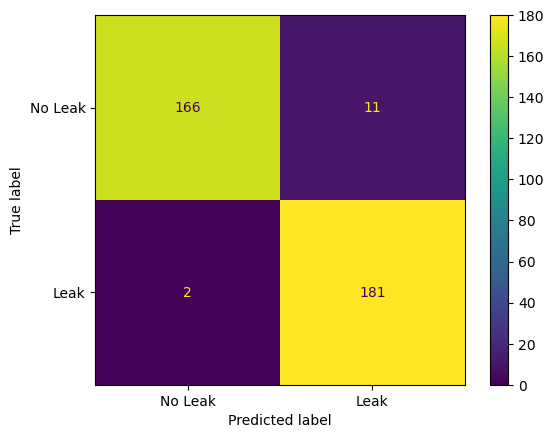

In [409]:
confusion_matrix = metrics.confusion_matrix(b4,results4)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Leak", "Leak"])
cm_display.plot()
cm_display.im_.set_clim(0, 180) #this is very imprtant
plt.show()

#### 2. CNN

In [412]:
for inputs, labels in val_dl: 
    a5 = modelc1(inputs)
    results5 = torch.argmax(a5, 1)
    acc = (results5 == labels).float().sum()
    b5 = labels
    print(acc/len(b5))


tensor(0.9806)


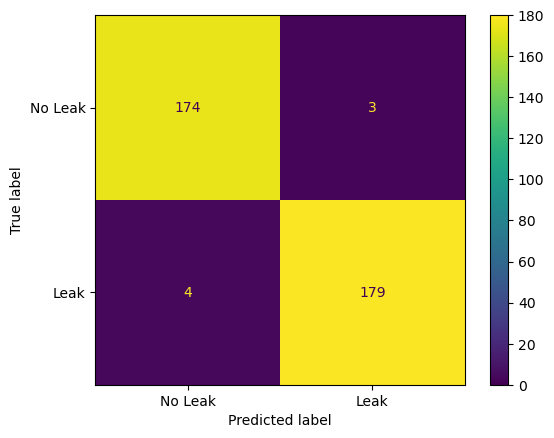

In [413]:
confusion_matrix = metrics.confusion_matrix( b5,results5)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Leak", "Leak"])
cm_display.plot()
cm_display.im_.set_clim(0, 180) #this is very imprtant
plt.show()

#### 3. ROC curve: 

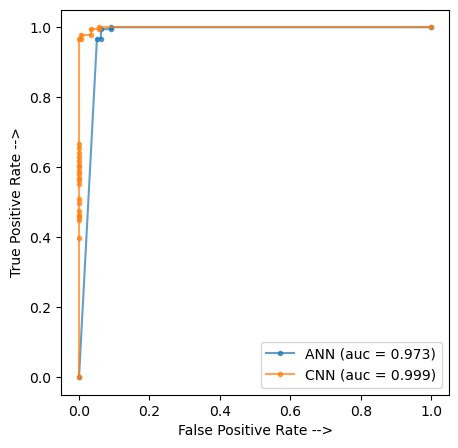

In [416]:
from sklearn.metrics import roc_curve, auc

with torch.no_grad():
    cnn_fpr, cnn_tpr, threshold = roc_curve(b5, a5[:,1])
    auc_cnn = auc(cnn_fpr, cnn_tpr)
    ann_fpr, ann_tpr, threshold = roc_curve(b4, a4[:,1])
    auc_ann = auc(ann_fpr, ann_tpr)

    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(ann_fpr, ann_tpr, linestyle='-',marker='.', label='ANN (auc = %0.3f)' % auc_ann, alpha = 0.7)
    plt.plot(cnn_fpr, cnn_tpr, marker='.', label='CNN (auc = %0.3f)' % auc_cnn, alpha = 0.7)

    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')

    plt.legend()

    plt.show()

#### General summary:

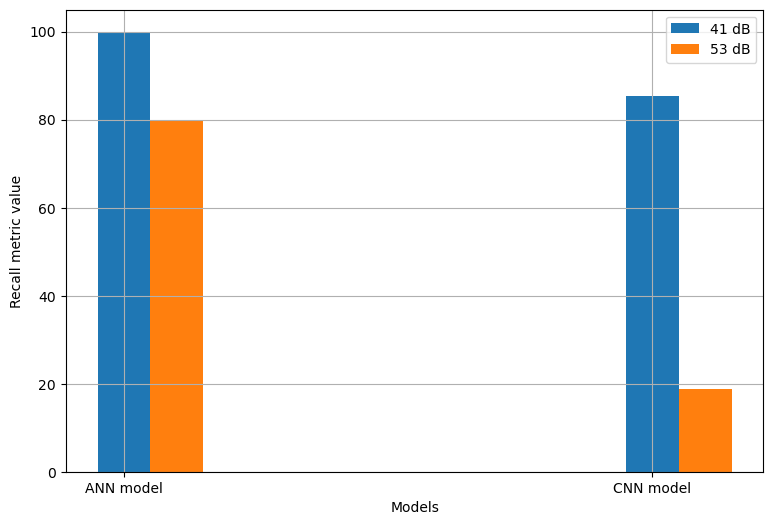

In [118]:
x = np.array([0,0.5])
y1 = [100,85.3]
y2 = [80,18.91]

width = 0.05
  
# plot data in grouped manner of bar type
plt.figure (figsize = (9,6))
plt.bar(x, y1, width)
plt.bar(x+0.05, y2, width)
plt.xticks(x, ['ANN model', 'CNN model'])
plt.xlabel("Models")
plt.ylabel("Recall metric value")
plt.legend(["41 dB", "53 dB"])
#plt.savefig("The scores of the models")
plt.grid()
plt.show()

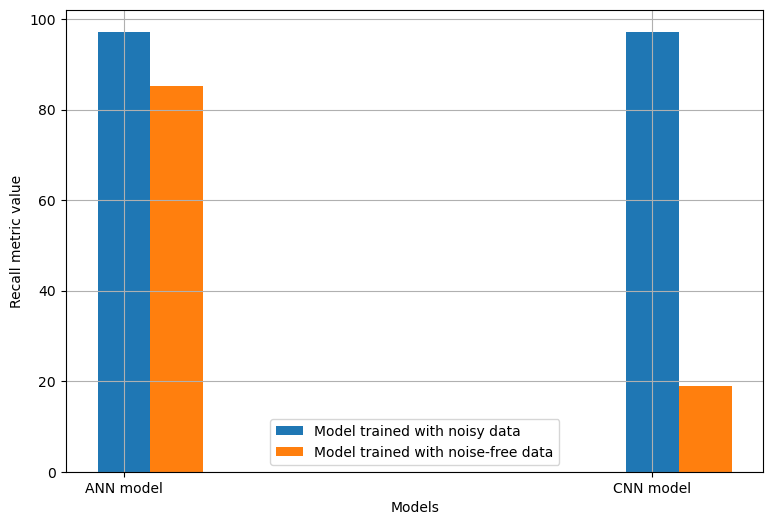

In [212]:
x = np.array([0,0.5])
y1 = [97.23,97.23]
y2 = [85.3,18.91]

width = 0.05
  
# plot data in grouped manner of bar type
plt.figure (figsize = (9,6))
plt.bar(x, y1, width)
plt.bar(x+0.05, y2, width)
plt.xticks(x, ['ANN model', 'CNN model'])
plt.xlabel("Models")
plt.ylabel("Recall metric value")
plt.legend(["Model trained with noisy data", "Model trained with noise-free data"])
#plt.savefig("The scores of the models")
plt.grid()
plt.show()